## Import all needed modules

In [1]:
import sys
import subprocess

if 'darwin' in sys.platform:
    print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
    subprocess.Popen('caffeinate')

Running 'caffeinate' on MacOSX to prevent the system from sleeping


In [2]:
import requests 
import string
from bs4 import BeautifulSoup  
import logging  
logging.basicConfig(level=logging.DEBUG)
import dateutil.parser
import time
import re
from collections import OrderedDict
import pandas as pd
from datetime import datetime
import numpy as np

## Get movie urls from boxofficemojo.com

In [3]:
def get_all_movies():  
    """ returns all the movie urls from boxofficemojo.com in a list"""

    # Alphabet loop for how movies are indexed including
    # movies that start with a special character or number
    index = ["NUM"] + list(string.ascii_uppercase)

    # List of movie urls
    movies_list = []

    # Loop through the pages for each letter
    for letter in index:

        # Loop through the pages within each letter
        for num in range(1, 20):
            url = ("http://www.boxofficemojo.com/movies/alphabetical.htm?"
                   "letter=" + letter + "&page=" + str(num))
            try:
                response = requests.get(url)
                page = response.text
                soup = BeautifulSoup(page, "lxml")
                rows = soup.find(id="body").find("table").find("table").find_all(
                    "table")[1].find_all("tr")

                # skip index row
                if len(rows) > 1:
                    counter = 1
                    for row in rows:
                        # skip index row
                        if counter > 1:
                            link = row.td.font.a['href']
                            # don't add duplicates
                            if link not in movies_list:
                                movies_list.append(link)

                        counter += 1
            except (Exception, e):
                logging.exception(e)

    return movies_list

#### To get the url of the movies, call the function defined above 

In [4]:
all_movies = get_all_movies()

## Define certain useful functions

In [5]:
def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text # RETURN TEXT OF NEXT SIBLING
    else:
        return None


def get_movie_value_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text # RETURN TEXT OF NEXT SIBLING
    else:
        return None



#def get_movie_value_next_next(soup, field_name):
#    '''Grab a value from boxofficemojo HTML
#    
#    Takes a string attribute of a movie on the page and
#    returns the string in the next sibling object
#    (the value for that attribute)
#    or None if nothing is found.
#    '''
#    obj = soup.find(text=re.compile(field_name))
#    
#    if obj:
#        return obj.next.next.text
#    else:
#        return None

def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    
    for br in soup.findAll('br'):
        br.replace_with('\n')
    
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text 
    else:
        return None

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)


def money_to_int_2(string):
    if string is not None:
        i = string.replace('$','').replace(',','').replace(' ','')
        if "million" in i:
            i = i.replace('million','')
            i = float(i) * 1000000
            i = int(i)
        return i
    else:
        return np.nan

def money_to_int_3(moneystring):
    moneystring = moneystring.replace('\xa0','').replace('$', '').replace(',','')
    

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def strip_and_return_int(s):
    t = s.replace('$', '').replace(',','')
    t = int(t)
    return t

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

## Define functions to get movie information

In [6]:
def movie_title(soup):        
    #try:
    title_string = soup.find('title').text
    title = title_string.split('(')[0].strip()
    #except:
        #title = float('NaN')
        
    return title 
    
def movie_producers(soup):
    try:
        producer = get_movie_value_next(soup, 'Producer')
        producers = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', producer).split(",") 
    except TypeError:
        producers = float('NaN')
    except AttributeError:
        producers = float('NaN')
        
    return producers
        
def movie_directors(soup):
    try:
        director = get_movie_value_next(soup,'Director')
        director = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', director).split(",") 
    except TypeError:
        director = float('NaN')
    
    return director
    

def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        if str(actor) != 'None':
            actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
            actors = actors.split(", ")
            return actors

    except TypeError:
        return actors

def movie_genre(soup):
    try:
        genre = get_movie_value(soup, 'Genre[^a-z]')
    except:
        genre = float('NaN')
    return genre

def movie_rating(soup):
    try:
        rating = get_movie_value(soup,'MPAA Rating')
    except:
        rating = float('NaN')
    return rating

#def release_date(soup):
#    try:
#        raw_release_date = get_movie_value(soup,'Release Date')
#        if raw_release_date != 'TBD' and raw_release_date != 'N/A' and raw_release_date[0].isnumeric() :
#            release_date = to_date(raw_release_date)
#        else:
#            release_date = float('NaN')
#    except AttributeError:
#        release_date = float('NaN')
#    
#    return release_date

def release_date(soup):
    try:
        raw_release_date = get_movie_value(soup,'Release Date')
        if raw_release_date != 'TBD' and raw_release_date != 'N/A' and raw_release_date.split()[0] != 'Spring' and raw_release_date.split()[0] != 'Summer' and raw_release_date.split()[0] != 'Fall' and raw_release_date.split()[0] != 'Winter' :
            release_date = to_date(raw_release_date)
        else:
            release_date = float('NaN')
    except AttributeError:
        release_date = float('NaN')
    return release_date
    
def domestic_gross(soup):
    
    try:
        raw_domestic_total_gross = get_movie_value(soup,'Domestic Total')
        domestic_total_gross = money_to_int(raw_domestic_total_gross)
    except AttributeError:
        domestic_total_gross = float('NaN')
    
    return domestic_total_gross
    
def opening_weekend_gross(soup):
    
    try:
        opening_weekend_gross = get_movie_value_next(soup,'Opening\xa0Weekend:')
        opening_weekend_gross = money_to_int_3(opening_weekend_gross)
    except AttributeError:
        opening_weekend_gross = float('NaN')
    return opening_weekend_gross
    
def production_budget(soup):
    try:
        production_budget = get_movie_value(soup, 'Production Budget')
        production_budget = money_to_int_2(production_budget)
    except AttributeError:
        production_budget = float('NaN')
    return production_budget
    
def runtime(soup):
    try:
        raw_runtime = get_movie_value(soup,'Runtime')
        runtime = runtime_to_minutes(raw_runtime)
    except AttributeError:
        runtime = float('NaN')
    return runtime
    
def widest_release(soup):
    try:
        widest_release = get_movie_value_next_next(soup, 'Widest')
        widest_release = strip_and_return_int(widest_release.split()[0])
    except AttributeError:
        widest_release = float('NaN')
    return widest_release

def distributor(soup):
    try:
        if str(soup.find(id='body')) != 'None':
            distributor = soup.find(id="body").find(text=re.compile("Distributor"))
            if str(distributor) != 'None':
                distributor = distributor.findNextSibling().text
                return distributor
    except LookupError:
        distributor = float('NaN')


## MOVIE SCRAPER

In [18]:
def movie_scraper(all_movies):    
    movie_blocks = list(range(0, len(all_movies)-1, int(len(all_movies)/10)))
    movie_blocks.append(len(all_movies)-1) 
            
    print("The length of urls_chunks, minus one is %s" % str(len(movie_blocks)-1))
    
    movie_data_list = OrderedDict()
    count = 0 
    try:
        for block_index in range(len(movie_blocks) - 1):
                    
            print ("URL chunk ... %s of %s in 10 seconds ... \n" % (str(block_index), str(len(movie_blocks) - 1)))
            
            time.sleep(10)
            
            print ("Fetching URLs in movie_list location: %s to %s \n" % (movie_blocks[block_index], movie_blocks[block_index + 1]))
            for movie in all_movies[movie_blocks[block_index]:movie_blocks[block_index + 1]]:
                count +=1
                url = "http://www.boxofficemojo.com/" + movie
                response = requests.get(url)
                time.sleep(0.1)
                page = response.text
                soup = BeautifulSoup(page, "lxml")
                print(count,movie)
                movie_data_list[movie_title(soup)] = [movie, movie_genre(soup), release_date(soup), 
                                                        distributor(soup), runtime(soup), 
                                                        movie_rating(soup), production_budget(soup), 
                                                        domestic_gross(soup), movie_actors(soup), 
                                                        opening_weekend_gross(soup), widest_release(soup),
                                                        movie_producers(soup), movie_directors(soup) ]
                        
                
                
                #try:
                #    time.sleep(0.2)
                #    response = requests.get(url)
                #    page = response.text
                #    #print(str(re.search('\w+(?=\.htm)', url).group()))
                #    soupObjects[str(re.search('\w+(?=\.htm)',url).group())] = BeautifulSoup(page,'lxml')
                #except requests.exceptions.RequestException as e:
                #    print(e)
                #    sys.exit(1)
                #
                    
            print("continuing in 10 seconds ...")
    except requests.exceptions.RequestException as e:
        print(e)
        pass
        #sys.exit(1)
            
    return movie_data_list


In [8]:
dict_1 = movie_scraper(all_movies)

The length of urls_chunks, minus one is 31
URL chunk ... 0 of 31 in 10 seconds ... 

Fetching URLs in movie_list location: 0 to 556 

1 /movies/?id=horrorifc.htm
2 /movies/?id=9dot99.htm
3 /movies/?id=supercapitalist.htm
4 /movies/?id=500daysofsummer.htm
5 /movies/?id=untitled.htm
6 /movies/?id=andjusticeforall.htm
7 /movies/?id=1mileabove.htm
8 /movies/?id=1plus1.htm
9 /movies/?id=1000rupeenote.htm
10 /movies/?id=1000times.htm
11 /movies/?id=10.htm
12 /movies/?id=badrobot2016.htm
13 /movies/?id=10daysinamadhouse.htm
14 /movies/?id=10itemsorless.htm
15 /movies/?id=10questionsforthedalailama.htm
16 /movies/?id=10rules.htm
17 /movies/?id=10thingsihateaboutyou.htm
18 /movies/?id=10tomidnight.htm
19 /movies/?id=10years.htm
20 /movies/?id=10000bc.htm
21 /movies/?id=10000km.htm
22 /movies/?id=100bloodyacres.htm
23 /movies/?id=100yearoldman.htm
24 /movies/?id=1001grams.htm
25 /movies/?id=101dalmations.htm
26 /movies/?id=101dalmatiansliveaction.htm
27 /movies/?id=101dalmatians69.htm
28 /movies

In [9]:
df = pd.DataFrame(dict_1)

In [24]:
df.to_pickle('001.pkl')

In [12]:
dict_2 = movie_scraper(all_movies[1522:])

The length of urls_chunks, minus one is 31
URL chunk ... 0 of 31 in 10 seconds ... 

Fetching URLs in movie_list location: 0 to 505 

1 /movies/?id=benhur25.htm
2 /movies/?id=benhur2016.htm
3 /movies/?id=benchwarmers.htm
4 /movies/?id=benditlikebeckham.htm
5 /movies/?id=bendabilili.htm
6 /movies/?id=beneaththedarkness.htm
7 /movies/?id=beneaththeharvestsky.htm
8 /movies/?id=beneaththeplanetoftheapes.htm
9 /movies/?id=thebenefactor.htm
10 /movies/?id=benjaminsmoke.htm
11 /movies/?id=benji.htm
12 /movies/?id=benji04.htm
13 /movies/?id=benjithehunted.htm
14 /movies/?id=bennyandjoon.htm
15 /movies/?id=bent.htm
16 /movies/?id=beowulf.htm
17 /movies/?id=beowulfandgrendel.htm
18 /movies/?id=berberiansoundstudio.htm
19 /movies/?id=bereavement.htm
20 /movies/?id=berkeley.htm
21 /movies/?id=berlinfile.htm
22 /movies/?id=bernie.htm
23 /movies/?id=bertrigbyyoureafool.htm
24 /movies/?id=bertstern.htm
25 /movies/?id=besharam.htm
26 /movies/?id=besieged.htm
27 /movies/?id=besotted.htm
28 /movies/?id=

In [13]:
df2 = pd.DataFrame(dict_2)

In [25]:
df2.to_pickle('002.pkl')

In [ ]:
dict_3 = movie_scraper(all_movies[7200:])

The length of urls_chunks, minus one is 11
URL chunk ... 0 of 11 in 10 seconds ... 

Fetching URLs in movie_list location: 0 to 948 

1 /movies/?id=ifyoubuildit.htm
2 /movies/?id=ifyoucouldseewhatihear.htm
3 /movies/?id=ifyoudontiwill.htm
4 /movies/?id=if.htm
5 /movies/?id=igbygoesdown.htm
6 /movies/?id=igor.htm
7 /movies/?id=ikiru02.htm
8 /movies/?id=ilbarbieredisiviglia.htm
9 /movies/?id=ilcuorealtrove.htm
10 /movies/?id=ildivo.htm
11 /movies/?id=ilfuturo.htm
12 /movies/?id=ilnefautjurerderien.htm
13 /movies/?id=ilpostino.htm
14 /movies/?id=ilposto.htm
15 /movies/?id=iltritticoatlascala.htm
16 /movies/?id=illgottengains.htm
17 /movies/?id=illegal2011.htm
18 /movies/?id=illegaltender.htm
19 /movies/?id=illegallyyours.htm
20 /movies/?id=illuminata.htm
21 /movies/?id=illumination2019.htm
22 /movies/?id=illumination2020.htm
23 /movies/?id=illusion.htm
24 /movies/?id=illusionist.htm
25 /movies/?id=illusionist2010.htm
26 /movies/?id=illustratedman.htm
27 /movies/?id=iloilo.htm
28 /movies/?

In [21]:
df3 = pd.DataFrame(dict_3)

In [26]:
df3.to_pickle('003.pkl')

In [27]:
dict_4 = movie_scraper(all_movies[10284:])

The length of urls_chunks, minus one is 11
URL chunk ... 0 of 11 in 10 seconds ... 

Fetching URLs in movie_list location: 0 to 639 

1 /movies/?id=mylifesofar.htm
2 /movies/?id=mylifewithoutme.htm
3 /movies/?id=mylifesinturnaround.htm
4 /movies/?id=mylittlechickadee.htm
5 /movies/?id=mylittlegirl.htm
6 /movies/?id=mylittlepony.htm
7 /movies/?id=mylittlepony2017.htm
8 /movies/?id=dontcrossthatriver.htm
9 /movies/?id=myluckystar.htm
10 /movies/?id=mymexicanshivah.htm
11 /movies/?id=mymotherlikeswomen.htm
12 /movies/?id=mymotherscastle.htm
13 /movies/?id=mymotherssmile.htm
14 /movies/?id=mynameisbruce.htm
15 /movies/?id=mynameisjoe.htm
16 /movies/?id=mynameiskhan.htm
17 /movies/?id=mynewgun.htm
18 /movies/?id=myoldlady.htm
19 /movies/?id=myoneandonly.htm
20 /movies/?id=myownprivateidaho.htm
21 /movies/?id=myperestroika.htm
22 /movies/?id=mypieceofthepie.htm
23 /movies/?id=myreincarnation.htm
24 /movies/?id=myscienceproject.htm
25 /movies/?id=mysisterskeeper.htm
26 /movies/?id=mysonthefan

In [28]:
df4 = pd.DataFrame(dict_4)

In [34]:
df4.to_pickle('004.pkl')

In [35]:
dict_5 = movie_scraper(all_movies[15372:])

The length of urls_chunks, minus one is 10
URL chunk ... 0 of 10 in 10 seconds ... 

Fetching URLs in movie_list location: 0 to 131 

1 /movies/?id=undefeated.htm
2 /movies/?id=undefeated11.htm
3 /movies/?id=undefeated2012.htm
4 /movies/?id=underfire.htm
5 /movies/?id=undermyskin.htm
6 /movies/?id=underourskin.htm
7 /movies/?id=undersiege.htm
8 /movies/?id=undersiege2.htm
9 /movies/?id=undersuspicion.htm
10 /movies/?id=undersuspicion92.htm
11 /movies/?id=undertheboardwalk.htm
12 /movies/?id=underboardwalk.htm
13 /movies/?id=underthecherrymoon.htm
14 /movies/?id=underthedomimtree.htm
15 /movies/?id=undertheelectricsky.htm
16 /movies/?id=undertherainbow.htm
17 /movies/?id=underthesamemoon.htm
18 /movies/?id=underthesand.htm
19 /movies/?id=underthesea3d.htm
20 /movies/?id=undertheshadow.htm
21 /movies/?id=undertheskin.htm
22 /movies/?id=undertheskin2014.htm
23 /movies/?id=undertheskinofthecity.htm
24 /movies/?id=underthesun.htm
25 /movies/?id=underthesun2016.htm
26 /movies/?id=underthesun

In [38]:
df5 = pd.DataFrame(dict_5)

In [39]:
df5.to_pickle('005.pkl')

In [40]:
dict_6 = movie_scraper(all_movies[15881:])

The length of urls_chunks, minus one is 11
URL chunk ... 0 of 11 in 10 seconds ... 

Fetching URLs in movie_list location: 0 to 80 

1 /movies/?id=wasabituna.htm
2 /movies/?id=wasabituna05.htm
3 /movies/?id=wash.htm
4 /movies/?id=washdryandspinout.htm
5 /movies/?id=washingtonheights.htm
6 /movies/?id=washingtonsquare.htm
7 /movies/?id=wassuprockers.htm
8 /movies/?id=wasteland.htm
9 /movies/?id=thewastedtimes.htm
10 /movies/?id=neighborhoodwatch.htm
11 /movies/?id=watcher.htm
12 /movies/?id=watcherinthewoods.htm
13 /movies/?id=watchers.htm
14 /movies/?id=watchersofthesky.htm
15 /movies/?id=watchingtvwiththeredchinese.htm
16 /movies/?id=watchmen.htm
17 /movies/?id=water.htm
18 /movies/?id=water06.htm
19 /movies/?id=waterandpower.htm
20 /movies/?id=watercanada.htm
21 /movies/?id=waterdiviner.htm
22 /movies/?id=waterforelephants.htm
23 /movies/?id=waterhorse.htm
24 /movies/?id=waterlilies.htm
25 /movies/?id=waterboy.htm
26 /movies/?id=watercolors.htm
27 /movies/?id=waterdance.htm
28 /movie

In [41]:
df6 = pd.DataFrame(dict_6)

In [42]:
df6.to_pickle('006.pkl')

## transpose the dfs

In [43]:
df = df.transpose()
df2 = df2.transpose()
df3 = df3.transpose()
df4 = df4.transpose()
df5 = df5.transpose()
df6 = df6.transpose()

In [ ]:
df.columns = ['movie', 'genre','release date', 'distributor', 'runtime', 'rating', 'budget', 'domestic gross', 'actors', '1st weekend gross', 'widest release', 'producers', 'directors']

In [44]:
df_all = pd.concat([df, df2, df3, df4, df5, df6])

In [48]:
df_all.shape
df_all.columns = ['movie', 'genre','release date', 'distributor', 'runtime', 'rating', 'budget', 'domestic gross', 'actors', '1st weekend gross', 'widest release', 'producers', 'directors']

In [49]:
df_all.head()

,movie,genre,release date,distributor,runtime,rating,budget,domestic gross,actors,1st weekend gross,widest release,producers,directors
#Horror,/movies/?id=horrorifc.htm,Horror,2015-11-20 00:00:00,IFC,90,Unknown,N/A,NaN,"[Balthazar Getty, Timothy Hutton, Natasha Lyon...",NaN,NaN,NaN,NaN
$9.99,/movies/?id=9dot99.htm,Animation,2008-12-12 00:00:00,Regent Releasing,78,R,N/A,52384,None,NaN,4,NaN,NaN
$upercapitalist,/movies/?id=supercapitalist.htm,Thriller,2012-08-10 00:00:00,Truly Indie,96,Unrated,N/A,15919,None,NaN,1,NaN,NaN
,/movies/?id=untitled.htm,Comedy,2009-10-23 00:00:00,Samuel Goldwyn,96,R,N/A,230600,"[Adam Goldberg, Marley Shelton]",NaN,25,NaN,NaN
...And Justice for All,/movies/?id=andjusticeforall.htm,Drama,1979-10-19 00:00:00,Columbia,119,R,N/A,33300000,"[Craig T. Nelson, Al Pacino]",NaN,NaN,NaN,NaN


In [50]:
df_all['title'] = df_all.index

In [51]:
df_all.head()

,movie,genre,release date,distributor,runtime,rating,budget,domestic gross,actors,1st weekend gross,widest release,producers,directors,title
#Horror,/movies/?id=horrorifc.htm,Horror,2015-11-20 00:00:00,IFC,90,Unknown,N/A,NaN,"[Balthazar Getty, Timothy Hutton, Natasha Lyon...",NaN,NaN,NaN,NaN,#Horror
$9.99,/movies/?id=9dot99.htm,Animation,2008-12-12 00:00:00,Regent Releasing,78,R,N/A,52384,None,NaN,4,NaN,NaN,$9.99
$upercapitalist,/movies/?id=supercapitalist.htm,Thriller,2012-08-10 00:00:00,Truly Indie,96,Unrated,N/A,15919,None,NaN,1,NaN,NaN,$upercapitalist
,/movies/?id=untitled.htm,Comedy,2009-10-23 00:00:00,Samuel Goldwyn,96,R,N/A,230600,"[Adam Goldberg, Marley Shelton]",NaN,25,NaN,NaN,
...And Justice for All,/movies/?id=andjusticeforall.htm,Drama,1979-10-19 00:00:00,Columbia,119,R,N/A,33300000,"[Craig T. Nelson, Al Pacino]",NaN,NaN,NaN,NaN,...And Justice for All


In [52]:
df_all.to_pickle('all_movies_20161003.pkl')

In [179]:
DF = df_all.sort_values('release date')

NameError: name 'df_all' is not defined

In [59]:
DF.index = range(len(DF))

In [62]:
DF['release date'][0]

datetime.datetime(1919, 10, 3, 0, 0)

In [66]:
DF_90s = DF[DF['release date'] > datetime(1989, 12, 31, 0, 0)]

In [72]:
DF_90s.to_pickle('movies_from_the_90s.pkl')

# Work

In [180]:
import pandas as pd 

In [181]:
DF_90s = pd.read_pickle('movies_from_the_90s.pkl')

In [182]:
DF_90s['actors_no_nan'] = DF_90s['actors'].fillna('')

In [183]:
def strip_one_space(s):
    if s.endswith(" "): s = s[:-1]
    if s.startswith(" "): s = s[1:]
    return s

In [184]:
def unnest(df, col, reset_index=False):
    import pandas as pd
    col_flat = pd.DataFrame([[i, x] 
                       for i, y in df[col].apply(list).iteritems() 
                           for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')
    df = df.drop(col, 1)
    df = df.merge(col_flat, left_index=True, right_index=True)
    if reset_index:
        df = df.reset_index(drop=True)
    return df

In [185]:
expected = unnest(DF_90s, 'actors_no_nan')

In [186]:
expected['actors_no_nan_2'] = expected['actors_no_nan'].apply(strip_one_space)

In [187]:
expected.head()

,movie,genre,release date,distributor,runtime,rating,budget,domestic gross,actors,1st weekend gross,widest release,producers,directors,title,actors_no_nan,actors_no_nan_2
3447,/movies/?id=internalaffairs.htm,Crime Thriller,1990-01-12 00:00:00,Paramount,117,R,N/A,27734391,"[Richard Gere, Elijah Wood]",NaN,986,NaN,NaN,Internal Affairs,Richard Gere,Richard Gere
3447,/movies/?id=internalaffairs.htm,Crime Thriller,1990-01-12 00:00:00,Paramount,117,R,N/A,27734391,"[Richard Gere, Elijah Wood]",NaN,986,NaN,NaN,Internal Affairs,Elijah Wood,Elijah Wood
3448,/movies/?id=texaschainsaw3.htm,Horror,1990-01-12 00:00:00,New Line,81,R,N/A,5765562,[Viggo Mortensen],NaN,1107,NaN,NaN,Leatherface: The Texas Chainsaw Massacre III,Viggo Mortensen,Viggo Mortensen
3451,/movies/?id=downtown.htm,Action Comedy,1990-01-12 00:00:00,Fox,96,R,N/A,2346150,[Forest Whitaker],NaN,349,NaN,NaN,Downtown,Forest Whitaker,Forest Whitaker
3453,/movies/?id=tremors.htm,Horror Comedy,1990-01-19 00:00:00,Universal,95,PG-13,N/A,16667084,"[Kevin Bacon, Fred Ward]",NaN,1477,NaN,NaN,Tremors,Kevin Bacon,Kevin Bacon


In [188]:
DF_90s.shape

(14962, 15)

In [189]:
expected.shape

(27392, 16)

In [190]:
expected['count'] = 1

In [191]:
expected.shape

(27392, 17)

In [192]:
expected['genre'].value_counts()

Comedy                3875
Drama                 3783
Comedy / Drama        1454
Animation             1392
Thriller              1370
Romantic Comedy       1297
Unknown                910
Action                 818
Horror                 710
Action / Adventure     702
Romance                648
Crime Drama            622
Drama / Thriller       609
Period Drama           586
Action Comedy          547
Action Thriller        455
Fantasy                409
Family Comedy          400
Crime Comedy           390
Family Adventure       385
Sci-Fi Action          326
Sports Drama           302
Crime Thriller         279
Action Drama           257
Foreign                255
Music Drama            232
Western                215
Adventure              191
Fantasy Drama          189
Horror Thriller        189
                      ... 
Sports Comedy          167
Crime                  166
Sci-Fi Comedy          157
Sci-Fi Thriller        154
Sci-Fi                 153
War                    153
W

#### Genre functions

In [194]:
def comedy(s):
    if 'Comedy' in s:
        return 1
    else:
        return 0

def drama(s):
    if 'Drama' in s:
        return 1
    else:
        return 0

def animation(s):
    if 'Animation' in s:
        return 1
    else:
        return 0

def thriller(s):
    if 'Thriller' in s:
        return 1
    else:
        return 0 

def unknown(s):
    if 'Unknown' in s:
        return 1
    else:
        return 0

def action(s):
    if 'Action' in s:
        return 1
    else:
        return 0

def horror(s):
    if 'Horror' in s:
        return 1 
    else:
        return 0

def romance(s):
    if 'Romance' in s:
        return 1
    else:
        return 0

def fantasy(s):
    if 'Fantasy' in s:
        return 1
    else:
        return 0

def family(s):
    if 'Family' in s:
        return 1
    else:
        return 0

def sports(s):
    if 'Sports' in s:
        return 1
    else:
        return 0

def foreign(s):
    if 'Foreign' in s:
        return 1
    else:
        return 0

def music(s):
    if 'Music' in s:
        return 1
    elif 'Concert' in s:
        return 1
    else:
        return 0

def western(s):
    if 'Western' in s:
        return 1
    else:
        return 0

def crime(s):
    if 'Crime' in s:
        return 1
    else:
        return 0 
    
def sci_fi(s):
    if 'Sci-Fi' in s:
        return 1
    else:
        return 0

def war(s):
    if 'War' in s:
        return 1
    else:
        return 0
    
def documentary(s):
    if 'Documentary' in s:
        return 1
    else:
        return 0


In [195]:
expected['genre_comedy'] = expected['genre'].apply(comedy)
expected['genre_drama'] = expected['genre'].apply(drama)
expected['genre_animation'] = expected['genre'].apply(animation)
expected['genre_thriller'] = expected['genre'].apply(thriller)
expected['genre_unknown'] = expected['genre'].apply(unknown)
expected['genre_action'] = expected['genre'].apply(action)
expected['genre_horror'] = expected['genre'].apply(horror)
expected['genre_romance'] = expected['genre'].apply(romance)
expected['genre_fantasy'] = expected['genre'].apply(fantasy)
expected['genre_family'] = expected['genre'].apply(family)
expected['genre_sports'] = expected['genre'].apply(sports)
expected['genre_foreign'] = expected['genre'].apply(foreign)
expected['genre_music'] = expected['genre'].apply(music)
expected['genre_western'] = expected['genre'].apply(western)
expected['genre_crime'] = expected['genre'].apply(crime)
expected['genre_sci_fi'] = expected['genre'].apply(sci_fi)
expected['genre_war'] = expected['genre'].apply(war)
expected['genre_documentary'] = expected['genre'].apply(documentary)

In [197]:
expected.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', '1st weekend gross',
       'widest release', 'producers', 'directors', 'title', 'actors_no_nan',
       'actors_no_nan_2', 'count', 'genre_comedy', 'genre_drama',
       'genre_animation', 'genre_thriller', 'genre_unknown', 'genre_action',
       'genre_horror', 'genre_romance', 'genre_fantasy', 'genre_family',
       'genre_sports', 'genre_foreign', 'genre_music', 'genre_western',
       'genre_crime', 'genre_sci_fi', 'genre_war', 'genre_documentary'],
      dtype='object')

In [198]:
df_converted = expected.convert_objects(convert_dates = True, convert_numeric = True)

/Users/ausubo/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [200]:
df_converted['rating'].value_counts()

R                12990
PG-13             8985
PG                3318
Unrated           1036
Not Yet Rated      456
G                  423
Unknown            138
NC-17               46
Name: rating, dtype: int64

In [201]:
df_converted.shape

(27392, 35)

In [202]:
df_converted.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', '1st weekend gross',
       'widest release', 'producers', 'directors', 'title', 'actors_no_nan',
       'actors_no_nan_2', 'count', 'genre_comedy', 'genre_drama',
       'genre_animation', 'genre_thriller', 'genre_unknown', 'genre_action',
       'genre_horror', 'genre_romance', 'genre_fantasy', 'genre_family',
       'genre_sports', 'genre_foreign', 'genre_music', 'genre_western',
       'genre_crime', 'genre_sci_fi', 'genre_war', 'genre_documentary'],
      dtype='object')

In [204]:
del df_converted['1st weekend gross']
del df_converted['producers']
del df_converted['directors']
del df_converted['actors']
del df_converted['actors_no_nan']
df_converted['title'] = expected['title']

In [205]:
df_converted.shape

(27392, 30)

In [207]:
df_converted['title']

3447                                 Internal Affairs
3447                                 Internal Affairs
3448     Leatherface: The Texas Chainsaw Massacre III
3451                                         Downtown
3453                                          Tremors
3453                                          Tremors
3455                                          Streets
3458                                  Heart Condition
3459                                           Stella
3459                                           Stella
3461                                  Men Don't Leave
3461                                  Men Don't Leave
3461                                  Men Don't Leave
3467                                   Stanley & Iris
3470                                         Madhouse
3470                                         Madhouse
3470                                         Madhouse
3470                                         Madhouse
3472                        

In [211]:
df_sum = df_converted.groupby(['title','actors_no_nan_2']).sum()

In [212]:
df_sum

runtime      budget  \
title                          actors_no_nan_2                                
                               Adam Goldberg               96.0         NaN   
                               Marley Shelton              96.0         NaN   
#Horror                        Balthazar Getty             90.0         NaN   
                               Chloe Sevigny               90.0         NaN   
                               Natasha Lyonne              90.0         NaN   
                               Taryn Manning               90.0         NaN   
                               Timothy Hutton              90.0         NaN   
'71                            Jack O'Connell              99.0         NaN   
1,000 Times Good Night         Juliette Binoche           117.0         NaN   
                               Nikolaj Coster-Waldau      117.0         NaN   
10 Cloverfield Lane            John Gallagher Jr.         105.0         NaN   
                               John Goodman               105.0         NaN   
                               Mary Elizabeth Winstead    105.0         NaN   
10 Items or Less               Jonah Hill                  82.0         NaN   
                               Morgan Freeman              82.0         NaN   
                               Paz Vega                    82.0         NaN   
10 Rules for Sleeping Around   Chris Marquette             94.0         NaN   
                               Jesse Bradford              94.0         NaN   
10 Things I Hate About You     Heath Ledger                97.0  30000000.0   
                               Joseph Gordon-Levitt        97.0  30000000.0   
                               Julia Stiles                97.0  30000000.0   
10 Years                       Anthony Mackie             100.0         NaN   
                               Ari Graynor                100.0         NaN   
                               Aubrey Plaza               100.0         NaN   
                               Channing Tatum             100.0         NaN   
                               Chris Pratt                100.0         NaN   
                               Jenna Dewan-Tatum          100.0         NaN   
                               Justin Long                100.0         NaN   
                               Kate Mara                  100.0         NaN   
                               Lynn Collins               100.0         NaN   
...                                                         ...         ...   
Zoom                           Rip Torn                    83.0         NaN   
                               Spencer Breslin             83.0         NaN   
                               Tim Allen                   83.0         NaN   
Zootopia                       Alan Tudyk                 108.0         NaN   
                               Bonnie Hunt                108.0         NaN   
                               Ginnifer Goodwin           108.0         NaN   
                               Idris Elba                 108.0         NaN   
                               J.K. Simmons               108.0         NaN   
                               Jason Bateman              108.0         NaN   
                               Jenny Slate                108.0         NaN   
                               Octavia Spencer            108.0         NaN   
                               Tommy Chong                108.0         NaN   
crazy/beautiful                Kirsten Dunst               95.0  13000000.0   
demonlover                     Chloe Sevigny              120.0         NaN   
                               Gina Gershon               120.0         NaN   
eXistenZ                       Ian Holm                    90.0  15000000.0   
                               Jude Law                    90.0  15000000.0   
                               Sarah Polley                90.0  15000000.0   
                           

In [214]:
df_sum_other = df_converted.groupby('actors_no_nan_2').sum()

In [216]:
df_sum_other.reset_index()

,actors_no_nan_2,runtime,budget,domestic gross,widest release,count,genre_comedy,genre_drama,genre_animation,genre_thriller,...,genre_fantasy,genre_family,genre_sports,genre_foreign,genre_music,genre_western,genre_crime,genre_sci_fi,genre_war,genre_documentary
0,"""""Stone Cold"""" Steve Austin",295.0,8.000000e+07,1.030715e+08,3400.0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50 Cent,793.0,2.600000e+08,2.997157e+08,17571.0,7,1,2,0,4,...,0,0,0,0,1,0,2,0,0,0
2,A.J. Cook,93.0,NaN,3.567000e+03,1.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aaron Eckhart,3857.0,1.044950e+09,1.026238e+09,60963.0,37,7,16,0,5,...,0,0,2,0,0,1,1,3,0,0
4,Aaron Johnson,1159.0,5.040000e+08,7.576350e+08,21760.0,13,4,6,0,4,...,0,0,0,0,0,2,0,0,0,0
5,Aaron Paul,1341.0,3.220000e+08,3.114486e+08,16638.0,12,3,7,1,2,...,0,0,0,0,0,0,0,0,0,0
6,Aaron Stanford,293.0,NaN,3.433370e+05,43.0,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Aasif Mandvi,845.0,1.875000e+08,1.683686e+08,16443.0,9,4,2,1,3,...,0,0,1,0,0,0,0,0,0,0
8,Abbie Cornish,1541.0,4.875000e+08,3.585034e+08,24951.0,14,2,6,1,1,...,0,0,0,0,0,0,0,2,1,0
9,Abel Ferrara,88.0,NaN,1.179900e+04,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [228]:
df_sum_other['count'].value_counts()

1      566
2      326
3      198
4      147
5      131
6      101
7       85
8       84
9       69
10      65
11      51
13      49
12      45
17      42
14      40
19      37
18      37
16      37
15      36
28      32
22      32
21      26
20      26
25      25
26      21
35      17
24      17
30      16
29      16
33      16
      ... 
47       9
37       9
43       7
55       6
49       6
56       5
52       5
44       5
45       4
54       4
48       4
46       4
59       4
70       3
40       3
50       2
60       2
62       2
53       2
58       1
64       1
66       1
68       1
73       1
74       1
132      1
61       1
67       1
71       1
107      1
Name: count, dtype: int64

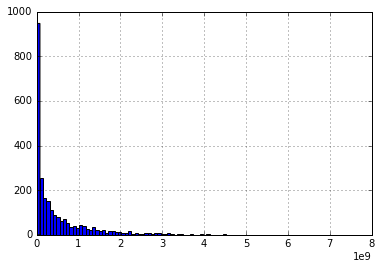

In [230]:
df_sum_other['domestic gross'].hist(bins = 100)

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

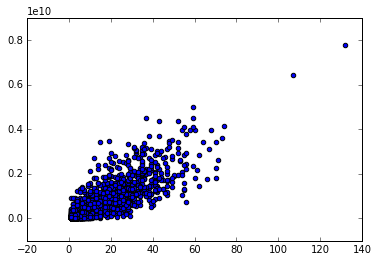

In [220]:
plt.scatter(df_sum_other['count'], df_sum_other['domestic gross'])

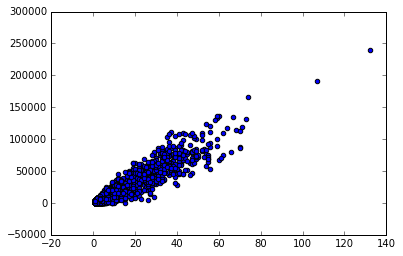

In [221]:
plt.scatter(df_sum_other['count'], df_sum_other['widest release'])

In [222]:
df_sum_other['money_per_movie'] = df_sum_other['domestic gross']/df_sum_other['count']

In [96]:
del df_sum['money_per movie']

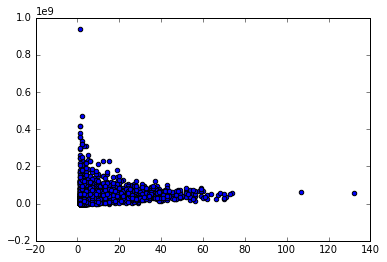

In [223]:
plt.scatter(df_sum_other['count'], df_sum_other['money_per_movie'])

In [30]:
df_sum.index

Index(['""Stone Cold"" Steve Austin', '50 Cent', 'A.J. Cook', 'Aaron Eckhart',
       'Aaron Johnson', 'Aaron Paul', 'Aaron Stanford', 'Aasif Mandvi',
       'Abbie Cornish', 'Abel Ferrara',
       ...
       'Zachary Gordon', 'Zachary Levi', 'Zachary Quinto', 'Zana Marjanovic',
       'Zhang Ziyi', 'Zoe Bell', 'Zoe Kazan', 'Zoe Saldana', 'Zoey Deutch',
       'Zooey Deschanel'],
      dtype='object', name='actors_no_nan_2', length=2614)

In [31]:
df_sum

,runtime,budget,domestic gross,1st weekend gross,widest release,producers,directors,count
actors_no_nan_2,,,,,,,,
"""""Stone Cold"""" Steve Austin",295.0,8.000000e+07,1.030715e+08,NaN,3400.0,NaN,NaN,3
50 Cent,793.0,2.600000e+08,2.997157e+08,NaN,17571.0,NaN,NaN,7
A.J. Cook,93.0,NaN,3.567000e+03,NaN,1.0,NaN,NaN,1
Aaron Eckhart,3857.0,1.044950e+09,1.026238e+09,NaN,60963.0,NaN,NaN,37
Aaron Johnson,1159.0,5.040000e+08,7.576350e+08,NaN,21760.0,NaN,NaN,13
Aaron Paul,1341.0,3.220000e+08,3.114486e+08,NaN,16638.0,NaN,NaN,12
Aaron Stanford,293.0,NaN,3.433370e+05,NaN,43.0,NaN,NaN,3
Aasif Mandvi,845.0,1.875000e+08,1.683686e+08,NaN,16443.0,NaN,NaN,9
Abbie Cornish,1541.0,4.875000e+08,3.585034e+08,NaN,24951.0,NaN,NaN,14


In [32]:
df_sum.shape

(2614, 8)

In [33]:
df_sum.drop_duplicates()

,runtime,budget,domestic gross,1st weekend gross,widest release,producers,directors,count
actors_no_nan_2,,,,,,,,
"""""Stone Cold"""" Steve Austin",295.0,8.000000e+07,1.030715e+08,NaN,3400.0,NaN,NaN,3
50 Cent,793.0,2.600000e+08,2.997157e+08,NaN,17571.0,NaN,NaN,7
A.J. Cook,93.0,NaN,3.567000e+03,NaN,1.0,NaN,NaN,1
Aaron Eckhart,3857.0,1.044950e+09,1.026238e+09,NaN,60963.0,NaN,NaN,37
Aaron Johnson,1159.0,5.040000e+08,7.576350e+08,NaN,21760.0,NaN,NaN,13
Aaron Paul,1341.0,3.220000e+08,3.114486e+08,NaN,16638.0,NaN,NaN,12
Aaron Stanford,293.0,NaN,3.433370e+05,NaN,43.0,NaN,NaN,3
Aasif Mandvi,845.0,1.875000e+08,1.683686e+08,NaN,16443.0,NaN,NaN,9
Abbie Cornish,1541.0,4.875000e+08,3.585034e+08,NaN,24951.0,NaN,NaN,14


In [34]:
df_sum.drop_duplicates().shape

(2417, 8)

In [226]:
df_sum_2.reset_index().sort_values(by = 'widest release' , ascending = False)

,actors_no_nan_2,runtime,budget,domestic gross,1st weekend gross,widest release,producers,directors,count
1281,Jr.,14734.0,4.126000e+09,7.793302e+09,NaN,239520.0,NaN,NaN,132
2075,Samuel L. Jackson,11663.0,3.895500e+09,6.446339e+09,NaN,190508.0,NaN,NaN,107
326,Bruce Willis,8034.0,2.766300e+09,4.159459e+09,NaN,166837.0,NaN,NaN,74
1609,Matt Damon,6807.0,2.498200e+09,3.942073e+09,NaN,136306.0,NaN,NaN,60
1816,Owen Wilson,6044.0,2.575000e+09,4.108224e+09,NaN,135955.0,NaN,NaN,59
1989,Robert DeNiro,7408.0,1.870400e+09,3.125871e+09,NaN,134956.0,NaN,NaN,67
1233,Johnny Depp,6595.0,4.298500e+09,5.004733e+09,NaN,133855.0,NaN,NaN,59
1841,Paul Giamatti,8400.0,2.097000e+09,3.587357e+09,NaN,130826.0,NaN,NaN,73
1740,Morgan Freeman,6493.0,2.444000e+09,3.979006e+09,NaN,130550.0,NaN,NaN,58
228,Ben Stiller,5425.0,2.206000e+09,3.942639e+09,NaN,124452.0,NaN,NaN,54


In [231]:
df_widest = df_sum_2.reset_index().sort_values(by = 'widest release' , ascending = False)

In [237]:
df_widest.head()

,actors_no_nan_2,runtime,budget,domestic gross,1st weekend gross,widest release,producers,directors,count
1281,Jr.,14734.0,4.126000e+09,7.793302e+09,NaN,239520.0,NaN,NaN,132
2075,Samuel L. Jackson,11663.0,3.895500e+09,6.446339e+09,NaN,190508.0,NaN,NaN,107
326,Bruce Willis,8034.0,2.766300e+09,4.159459e+09,NaN,166837.0,NaN,NaN,74
1609,Matt Damon,6807.0,2.498200e+09,3.942073e+09,NaN,136306.0,NaN,NaN,60
1816,Owen Wilson,6044.0,2.575000e+09,4.108224e+09,NaN,135955.0,NaN,NaN,59


In [239]:
df_widest = df_widest.drop(1281) 

In [242]:
df_widest.shape

(2416, 9)

In [244]:
del df_widest['1st weekend gross']
del df_widest['producers']
del df_widest['directors']

In [245]:
df_widest

,actors_no_nan_2,runtime,budget,domestic gross,widest release,count
2075,Samuel L. Jackson,11663.0,3.895500e+09,6.446339e+09,190508.0,107
326,Bruce Willis,8034.0,2.766300e+09,4.159459e+09,166837.0,74
1609,Matt Damon,6807.0,2.498200e+09,3.942073e+09,136306.0,60
1816,Owen Wilson,6044.0,2.575000e+09,4.108224e+09,135955.0,59
1989,Robert DeNiro,7408.0,1.870400e+09,3.125871e+09,134956.0,67
1233,Johnny Depp,6595.0,4.298500e+09,5.004733e+09,133855.0,59
1841,Paul Giamatti,8400.0,2.097000e+09,3.587357e+09,130826.0,73
1740,Morgan Freeman,6493.0,2.444000e+09,3.979006e+09,130550.0,58
228,Ben Stiller,5425.0,2.206000e+09,3.942639e+09,124452.0,54
1781,Nicolas Cage,6271.0,2.262000e+09,2.939055e+09,120757.0,56


In [252]:
df_widest['avg_movie_length'] = df_widest['runtime']/df_widest['count']

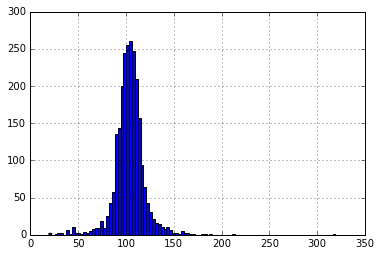

In [257]:
df_widest['avg_movie_length'].hist(bins = 100)

In [259]:
df_widest['avg_cost_movie'] = df_widest['budget']/df_widest['count']
df_widest['avg_dom_gross_movie'] = df_widest['domestic gross']/df_widest['count']


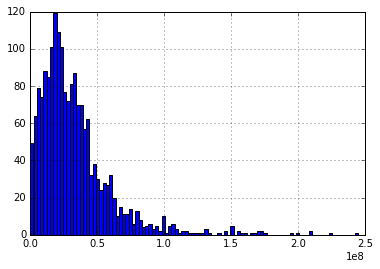

In [262]:
df_widest['avg_cost_movie'].hist(bins = 100)

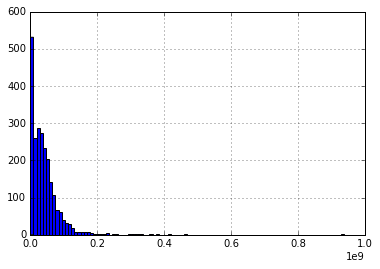

In [263]:
df_widest['avg_dom_gross_movie'].hist(bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12597d1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125e58cf8>]], dtype=object)

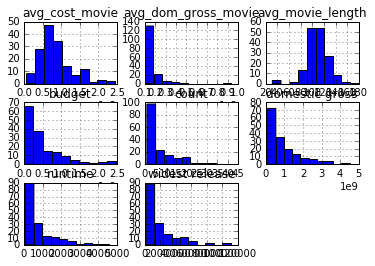

In [266]:
df_widest[df_widest['avg_dom_gross_movie'] >= 100000000].hist()

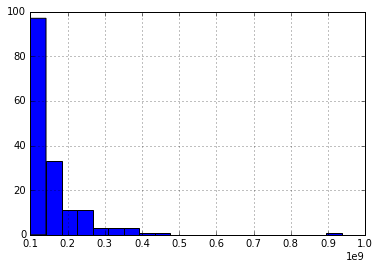

In [268]:
df_widest[df_widest['avg_dom_gross_movie'] >= 100000000]['avg_dom_gross_movie'].hist(bins = 20)

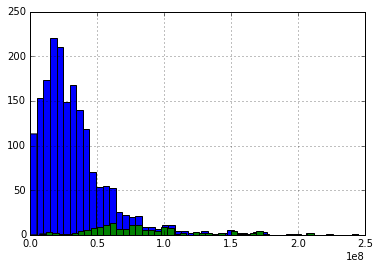

In [274]:
df_widest['avg_cost_movie'].hist(bins = 50)
df_widest[df_widest['avg_dom_gross_movie'] >= 100000000]['avg_cost_movie'].hist(bins = 50)

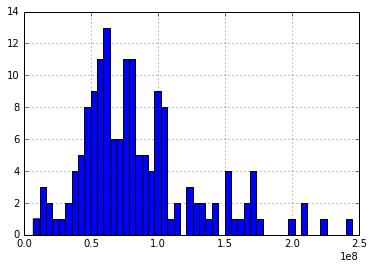

In [272]:
df_widest[df_widest['avg_dom_gross_movie'] >= 100000000]['avg_cost_movie'].hist(bins = 50)

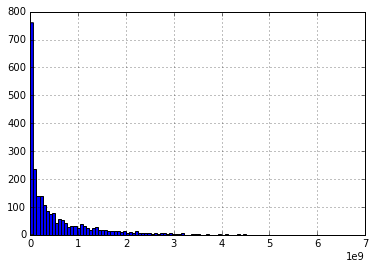

In [264]:
df_widest['domestic gross'].hist(bins= 100)

In [100]:
df_sum.sort_values(by = 'money_per_movie' , ascending = False)

,runtime,budget,domestic gross,widest release,count,money_per_movie
actors_no_nan_2,,,,,,
Kenny Baker,136.0,2.450000e+08,9.366622e+08,4134.0,1,9.366622e+08
Peter Mayhew,136.0,2.450000e+08,9.366622e+08,4134.0,2,4.683311e+08
Jodi Benson,103.0,2.000000e+08,4.150049e+08,4028.0,1,4.150049e+08
Lee Unkrich,103.0,2.000000e+08,4.150049e+08,4028.0,1,4.150049e+08
Bonnie Wright,130.0,NaN,3.810112e+08,4375.0,1,3.810112e+08
Richard Attenborough,127.0,6.300000e+07,3.570679e+08,2566.0,1,3.570679e+08
Phyllis Smith,94.0,1.750000e+08,3.564617e+08,4158.0,1,3.564617e+08
Emily VanCamp,283.0,4.200000e+08,6.678509e+08,8164.0,2,3.339255e+08
Regis Philbin,184.0,3.200000e+08,6.454399e+08,8344.0,2,3.227199e+08


In [ ]:
# /movies/?id=punchline.htm

In [ ]:
df.to_pickle('movies_1_v2.pkl')

In [ ]:
df.shape

In [ ]:
dict_2 = movie_scraper(all_movies[11924:])

In [ ]:
df2 = pd.DataFrame(dict_2)

In [ ]:
df2 = df2.transpose()
df2.columns = ['movie', 'genre','release date', 'distributor', 'runtime', 'rating', 'budget', 'domestic gross', 'actors', '1st weekend gross', 'widest release', 'producers', 'directors']
df2['title'] = df2.index
df2.index = range(len(df2))

In [ ]:
df2.to_pickle('movies_2.pkl')


## Miscellaneous

In [ ]:
def get_genres(soup):
    """ returns all genres from specific movie page at boxofficemojo.com"""
    genres_list = []
    try:
        genres = soup.find(id="body").find(text=re.compile("Genres"))
        genres = genres.findParent().findNextSibling().find_all('tr')
        genre_count = 0
        for genre in genres:
            if genre_count > 0:
                genres_list.append(genre.td.font.a.text)
            genre_count += 1
    except LookupError:
        try:
            genres = soup.find(id="body").find(text=re.compile("Genre"))
            genres = genres.findNextSibling().text
            genres_list.append(genres)
        except:
            genres_list.append("N/A")
    return genres_list


def get_title(soup):
    """returns title from specific movie page at boxofficemojo.com"""
    try:
        title = soup.find("title").text.rsplit('(', 1)[0].strip()
    except LookupError:
        title = "N/A"
    return title


def get_release_date(soup):
    """returns datetime value of release date from specific movie
    page at boxofficemojo.com
    """
    try:
        date = soup.find(id="body").find(text=re.compile("Release Date"))
        date = date.findNextSibling().text
        date = datetime.strptime(date, "%B %d, %Y")
        return date
    except LookupError:
        return "N/A"


def get_distributor(soup):
    """returns movie distributor from specific movie page at boxofficemojo.com"""
    try:
        distributor = soup.find(id="body").find(text=re.compile("Distributor"))
        distributor = distributor.findNextSibling().text
        return distributor
    except LookupError:
        return "N/A"


def get_rating(soup):
    """returns MPAA Rating from specific movie page at boxofficemojo.com"""
    try:
        rating = soup.find(id="body").find(text=re.compile("MPAA Rating"))
        rating = rating.findNextSibling().text
        return rating
    except LookupError:
        return "N/A"


def get_runtime(soup):
    """returns integer value of runtime from specific movie page at boxofficemojo.com"""
    try:
        runtime = soup.find(id="body").find(text=re.compile("Runtime"))
        runtime = runtime.findNextSibling().text
        time_splits = runtime.split("hrs.")
        try:
            hrs = int(time_splits[0]) * 60
        except LookupError:
            hrs = 0
        mins = int(time_splits[1].split(" min.")[0].strip())
        total = hrs + mins
        return total
    except LookupError:
        return "N/A"


def get_budget(soup):
    """returns movie budget from specific movie page at boxofficemojo.com"""
    try:
        budget = soup.find(id="body").find(text=re.compile("Production Budget"))
        budget = budget.findNextSibling().text
        if budget != "N/A":
            budget = int(budget.split("million")[0].split("$")[1].strip()) * 1000000
        return budget
    except LookupError:
        return "N/A"


def get_domestic_gross(soup):
    """returns integer value of domestic gross from specific movie page at boxofficemojo.com"""
    try:
        gross = soup.find(id="body").find(text=re.compile("Domestic Total Gross: "))
        gross = gross.findNextSibling().text
        gross = int(gross.replace("$", "").replace(",", ""))
        return gross
    except LookupError:
        try:
            gross = soup.find(id="body").find(tex=re.compile("Domestic:"))
            gross = gross.findParent().findNextSibling().text
            return gross
        except:
            return "N/A"
        
        
def get_movie_value_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.text
    else:
        return None

def get_actors(soup):
    actor = get_movie_value_next(soup,'Actor')
    v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
    actors = re.sub('[(*\']','', v)
    actors = actors.split(",")
    return actors


def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def get_opening_weekend(soup):
    opening_weekend_gross = get_movie_value_next(soup,'Opening Weekend')
    opening_weekend_gross = money_to_int(opening_weekend_gross)
    return opening_weekend_gross
    
    
def scrape_movie_data(movie_list, start=0, end=20000):
    """returns dictionary of movies and relevant data from boxofficemojo.com:
    genres(as a list), release date, distributor, runtime, MPAA rating,
    budget, gross domestic revenue
    """
    movie_data_list = {}
    counter = 0
    for movie in movie_list:
        try:
            if start < counter < end and counter < len(movie_list):
                url = "http://www.boxofficemojo.com/" + movie
                
                response = requests.get(url)
                time.sleep(0.1)
                page = response.text
                soup = BeautifulSoup(page, "lxml")
                print(movie)
                movie_data_list[get_title(soup)] = [get_genres(soup), get_release_date(soup), 
                                                    get_distributor(soup), get_runtime(soup), 
                                                    get_rating(soup), get_budget(soup), 
                                                    get_domestic_gross(soup), get_actors(soup), 
                                                    get_opening_weekend(soup)]
                
            counter += 1
        except: #(Exception, e):
            pass

    return movie_data_list


#def main():
#    pass

#if __name__ == "__main__":
#    main()

In [ ]:
movie_data_subset = scrape_movie_data(all_movies_subset, start=0, end=20000)

In [ ]:
movie_data_subset

In [ ]:
df = pd.DataFrame(movie_data_subset)

In [ ]:
df = df.transpose()

In [ ]:
movies_list_A = []
url = 'http://www.boxofficemojo.com/movies/alphabetical.htm?letter=A&page=1'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')
rows = soup.find(id = 'body').find('table').find('table').find_all('table')[1].find_all("tr")
if len(rows) > 1:
    counter = 1
    for row in rows:
    # skip index row
        if counter > 1:
            link = row.td.font.a['href']
            # don't add duplicates
            if link not in movies_list:
                movies_list_A.append(link)

        counter += 1

In [ ]:
def movie_actors(soup):
    try:
        actor = get_movie_value_next_next(soup,'Actor')
        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
        if "*" in v:
            actors = v.split('*')
        else:
            actors = re.sub('[(*\']','', v)
            actors = actors.split(",")
        #if "*" in actors:
        #    actors =  actors.split('*')

    except TypeError:
        actors = float('NaN')
    return actors

In [ ]:
def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text
    else:
        return None

In [ ]:
def get_movie_value_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text # RETURN TEXT OF NEXT SIBLING
    else:
        return None

In [ ]:
def release_date(soup):
    try:
        raw_release_date = get_movie_value(soup,'Release Date')
        if raw_release_date != 'TBD' and raw_release_date != 'N/A' and raw_release_date.split()[0] != 'Spring' and raw_release_date.split()[0] != 'Summer' and raw_release_date.split()[0] != 'Fall' and raw_release_date.split()[0] != 'Winter' :
            release_date = to_date(raw_release_date)
        else:
            release_date = float('NaN')
    except AttributeError:
        release_date = float('NaN')
    return release_date

In [ ]:
!pwd

In [ ]:
def get_actors(soup):
    actor = get_movie_value_next(soup,'Actor')
    v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
    v = v.replace('(, Voice)','')
    actors = re.sub('[(*\']','', v)
    actors = actors.split(",")
    return actors

In [ ]:
def movie_actors(soup):
    try:
        actor = get_movie_value_next_next(soup,'Actor')
        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
        if "*" in v:
            actors = v.split('*')
        else:
            actors = re.sub('[(*\']','', v)
            actors = actors.split(",")
        #if "*" in actors:
        #    actors =  actors.split('*')

    except TypeError:
        actors = float('NaN')
    return actors

In [ ]:
#url = 'http://www.boxofficemojo.com/movies/?id=disney2016.htm'
url = 'http://www.boxofficemojo.com/movies/?id=ghostbusters2016.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")

In [ ]:
get_movie_value_next_next(soup, 'Actor')

In [ ]:
actor = get_movie_value_next_next(soup,'Actor')

In [ ]:
actor

In [ ]:
def movie_actors(soup): # still doesn't deal well with McPeople
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        actor = actor.replace('*','')
        v = re.sub('([a-z()])([A-Z])', '\g<1>,\g<2>', actor)
        v = v.replace(' (,Voice)','')
        v = v.replace(' (,Cameo)','')
        actors = re.sub('[(*\']','', v)
        actors = actors.split(',')
        #if "*" in v:
        #    actors = v.split('*')
        #else:
        #    actors = re.sub('[(*\']','', v)
        #    actors = actors.split(",")

    except TypeError:
        actors = float('NaN')
    return actors

In [ ]:
# startswith()
# Mc, De, van, Mac, Du, Le

In [ ]:
print (movie_actors(soup))

In [ ]:
actor = get_movie_value_next_next(soup, 'Actor')

In [ ]:
actor = actor.replace('*','')

In [ ]:
actor

In [ ]:
s = actor.replace('(Cameo)','')

In [ ]:
v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)

In [ ]:
v

In [ ]:
#url = 'http://www.boxofficemojo.com/movies/?id=disney2016.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=ghostbusters2016.htm'
#url = "http://www.boxofficemojo.com/movies/?id=13goingon30.htm"
url = "http://www.boxofficemojo.com/movies/?id=9dot99.htm"
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")

In [ ]:
def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    
    for br in soup.findAll('br'):
        br.replace_with('\n')
    
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text 
    else:
        return None

In [ ]:
actor = get_movie_value_next_next(soup, 'Actor')

In [ ]:
actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')

In [ ]:
def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        if str(actor) != 'None':
            actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
            actors = actors.split(", ")
            #v = v.replace('(Voice)','')
            #v = v.replace('(Cameo)', '')
            #v = v.replace('\n','')
            #if "*" in v:
            #    actors = v.split('*')
            #else:
            #    actors = re.sub('[(*\']','', v)
            return actors

    except TypeError:
        #actors = float('NaN')
        return actors

In [ ]:
def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        if str(actor) != 'None':
            actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
            actors = actors.split(", ")
            return actors

    except TypeError:
        return actors

In [ ]:
print(movie_actors(soup))

In [ ]:
opening_weekend_gross(soup)

In [ ]:
#fix this here. ARGH!
#def money_to_int_2(moneystring):
#    if moneystring != 'N/A':
#        moneystring = moneystring.replace('$', '').replace('.','').replace(',','').replace(' million', '000000')
#        return int(moneystring)

#def money_to_int_2(moneystring):
#    if moneystring != 'N/A':
#        moneystring = moneystring.replace('$','').replace(',','')
#        if 'million' in moneystring:
#            moneystring.replace('million','')
#            return float(moneystring)*1000000
#        else:
#            return float(moneystring)

In [ ]:
#def get_movie_value_next_next(soup, field_name):
#    '''Grab a value from boxofficemojo HTML
#    
#    Takes a string attribute of a movie on the page and
#    returns the string in the next sibling object
#    (the value for that attribute)
#    or None if nothing is found.
#    '''
#    obj = soup.find(text=re.compile(field_name))
#    
#    if obj:
#        return obj.next.next.text
#    else:
#        return None

def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    
    for br in soup.findAll('br'):
        br.replace_with('\n')
    
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text 
    else:
        return None

In [ ]:
#def movie_actors(soup):
#    try:
#        actor = get_movie_value_next(soup,'Actor')
#        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
#        actors = re.sub('[(*\']','', v)
#        actors = actors.split(",") 
#    except TypeError:
#        actors = float('NaN')
#
#    return actors

#def movie_actors(soup):
#    try:
#        actor = get_movie_value_next(soup,'Actor')
#        if '*' in actor:
#            actors =  actor.split('*')
#        else:
#            v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
#            actors = re.sub('[(*\']','', v)
#            actors = actors.split(",") 
#    except TypeError:
#        actors = float('NaN')
#    return actors

#def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
#    try:
#        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
#        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
#        v = v.replace('(, Voice)','')
#        v = v.replace('(, Cameo)', '')
#        if "*" in v:
#            actors = v.split('*')
#        else:
#            actors = re.sub('[(*\']','', v)
#            actors = actors.split(",")
#
#    except TypeError:
#        actors = float('NaN')
#    return actors

#def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
#    try:
#        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
#        actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
#        #v = v.replace('(Voice)','')
#        #v = v.replace('(Cameo)', '')
#        #v = v.replace('\n','')
#        #if "*" in v:
#        #    actors = v.split('*')
#        #else:
#        #    actors = re.sub('[(*\']','', v)
#        actors = actors.split(", ")
#
#    except TypeError:
#        actors = float('NaN')
#    return actors
